In [39]:
import os
from collections import Counter
import tensorflow as tf
import numpy as np 
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

In [5]:
# Directory Path
dataset_path = "D:/task4/Car-Bike-Dataset"

# Get Class Names and Class Distribution
class_names = os.listdir(dataset_path)
class_distribution = Counter(
    os.path.join(dataset_path, class_name) 
    for class_name in class_names
)

# Display Information
num_classes = len(class_names)
print(f"Total Number of Classes: {num_classes}")
print("Class Names:", class_names)
print("Class Distribution:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count} instances")


Total Number of Classes: 2
Class Names: ['Bike', 'Car']
Class Distribution:
D:/task4/Car-Bike-Dataset\Bike: 1 instances
D:/task4/Car-Bike-Dataset\Car: 1 instances


In [23]:
# Image Data Generator
data_generator = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    validation_split=0.1
)
# Load Data
batch_size = 32
target_size = (256, 256)
train_ds = data_generator.flow_from_directory(
    dataset_path,
    class_mode='binary',
    target_size=target_size,
    shuffle=True,
    batch_size=batch_size,
    subset='training'
)

valid_ds = data_generator.flow_from_directory(
    dataset_path,
    class_mode='binary',
    target_size=target_size,
    shuffle=True,
    batch_size=batch_size,
    subset='validation'
)


Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [44]:
def display_images(grid_size=[4, 4], model=None, figsize=(20, 20), data=train_ds):
    num_rows = grid_size[0]
    num_cols = grid_size[1]
    num_images = num_cols * num_rows
    
    plt.figure(figsize=figsize)
    for i, (images, labels) in enumerate(data):
        for j in range(len(images)):
            if i * len(images) + j >= num_images:
                break

            image, true_label = images[j], class_names[int(labels[j])]
            plt.subplot(num_rows, num_cols, i * len(images) + j + 1)
            plt.imshow(image)
            
            if model is None:
                title = f"Class: {true_label}"
            else:
                prediction = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
                title = f"True: {true_label}\nPred: {prediction}"

            plt.title(title)
            plt.axis('off')

    plt.tight_layout()
    plt.show()



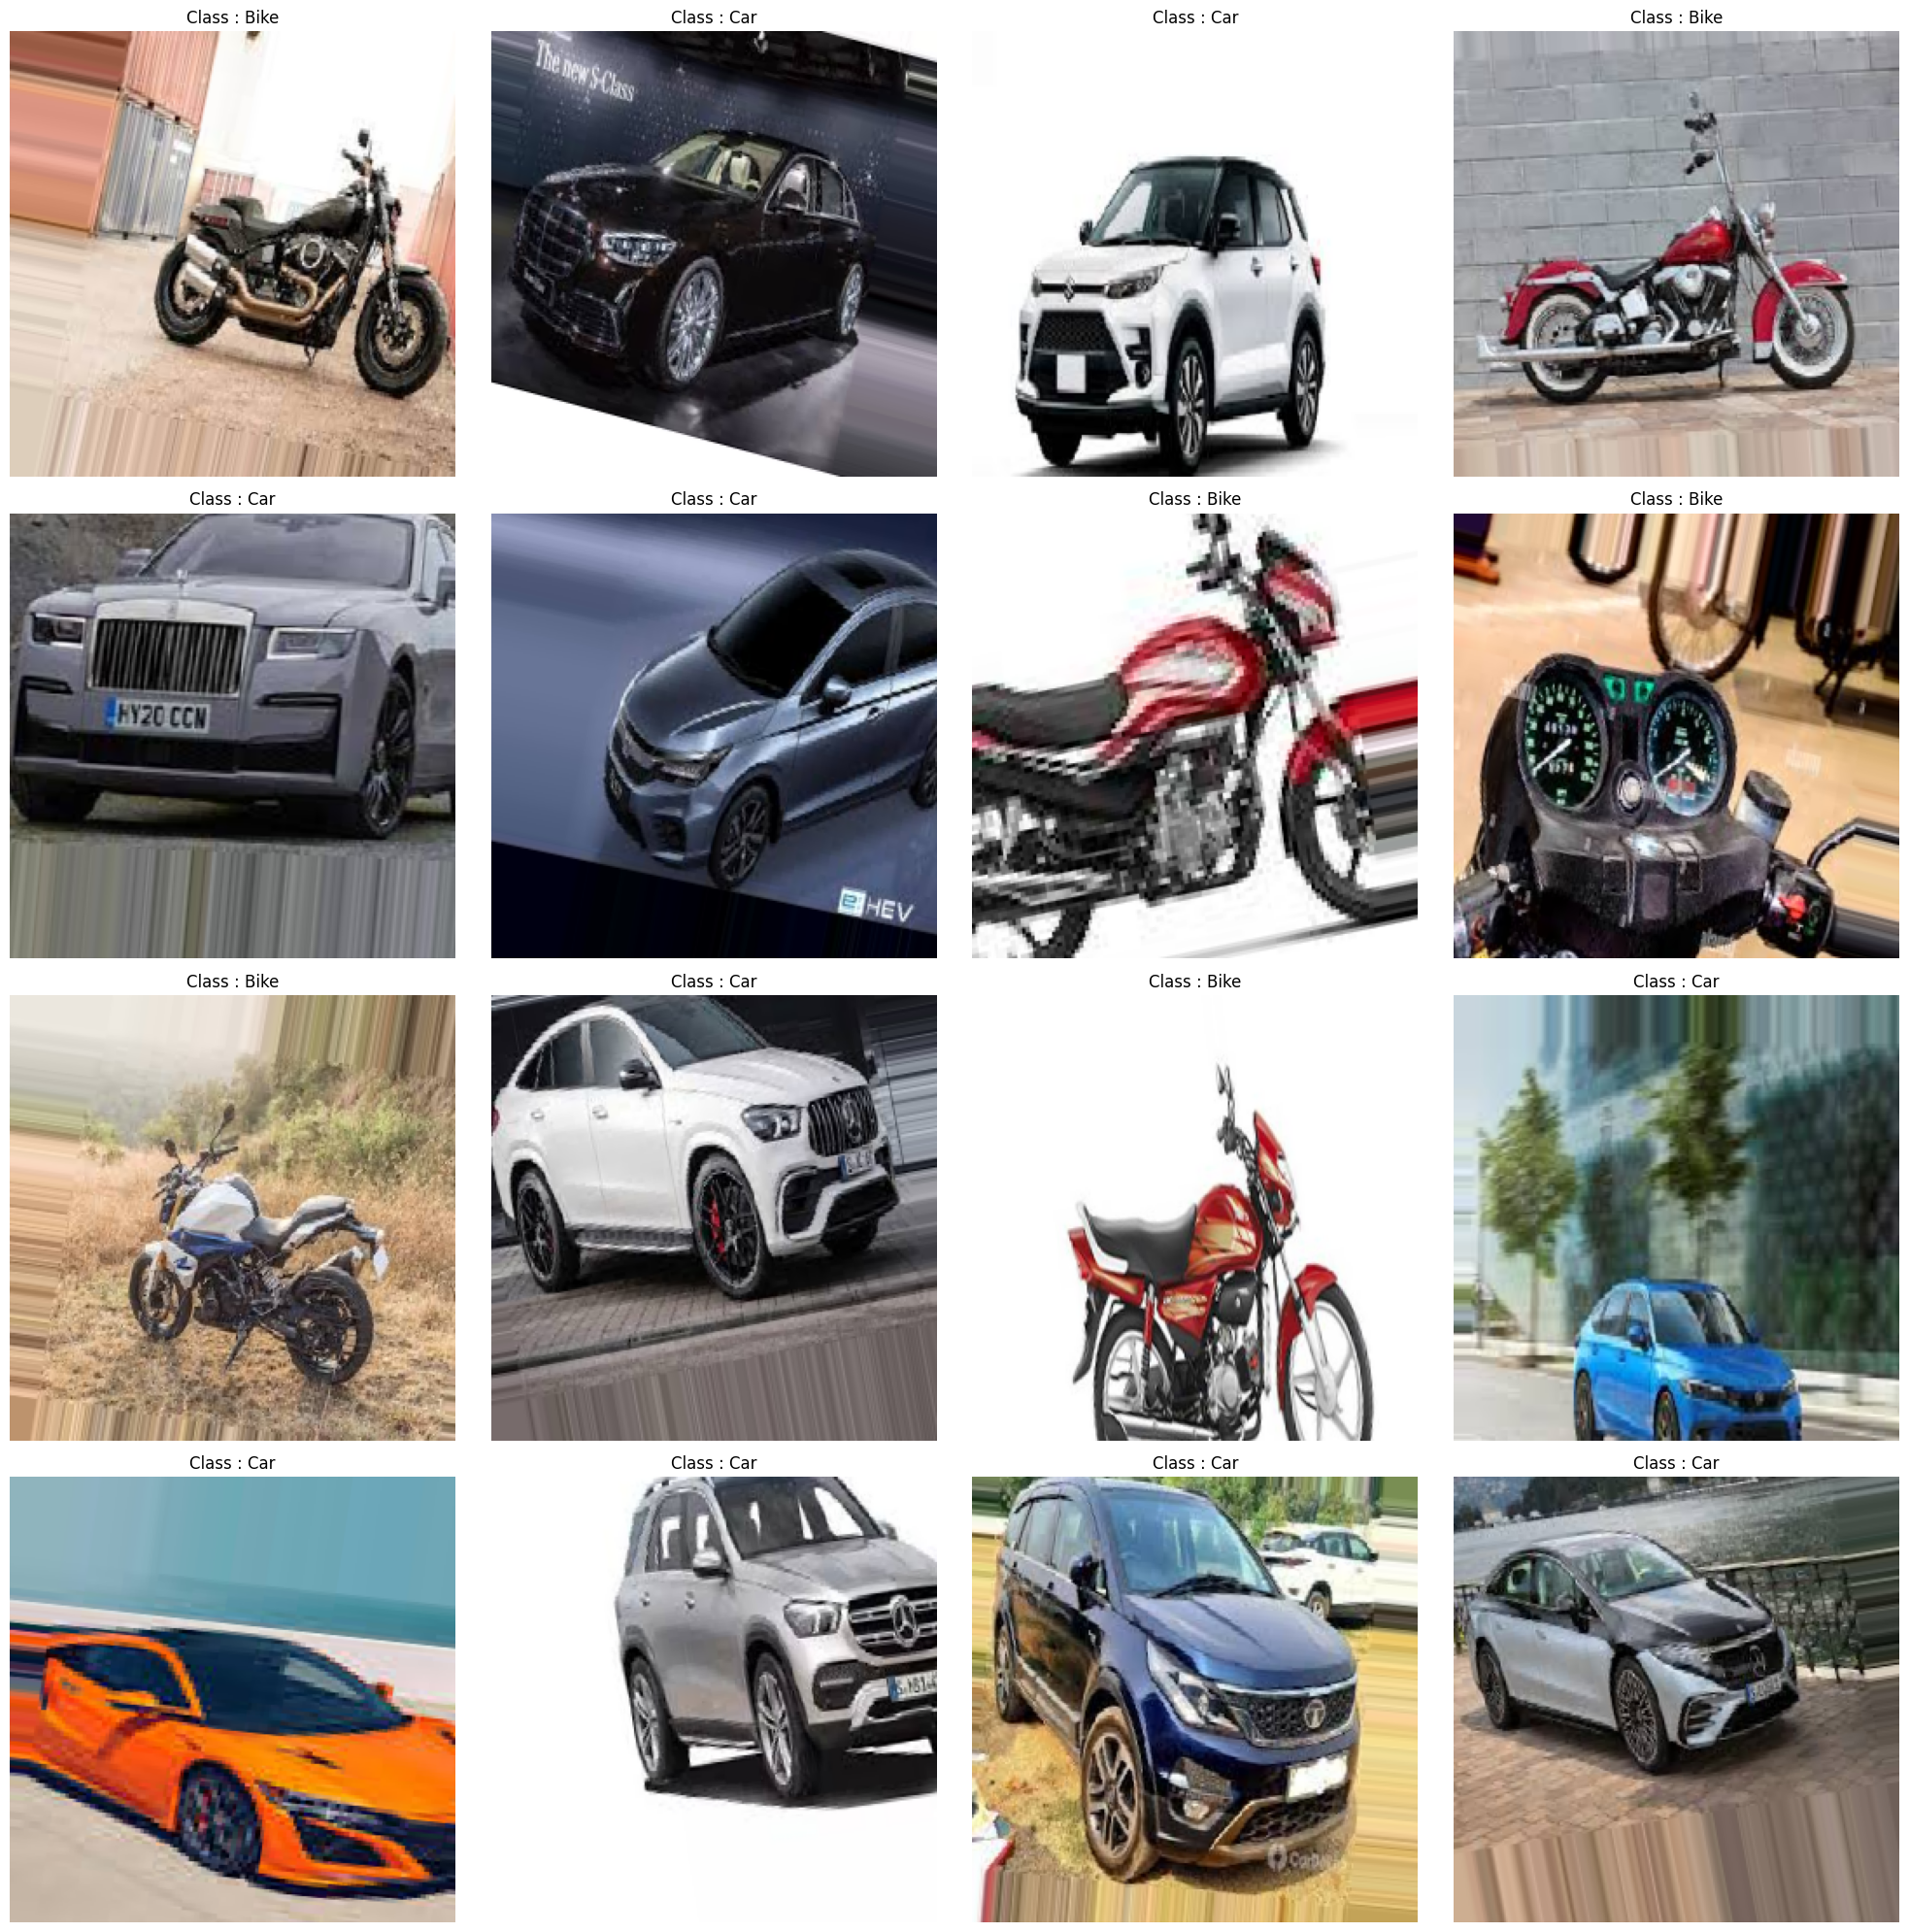

In [46]:
display_images()

In [13]:
# Trained Model 
base_model = ResNet50V2(input_shape=(256, 256, 3), include_top=False)
base_model.trainable = False

# Model Architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
], name="CustomResNetModel")

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("CustomResNetModel.h5", save_best_only=True)
]

# Model Compiling
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
model_train = model.fit(train_ds, validation_data=valid_ds, callbacks=callbacks, epochs=5)



Epoch 1/5
 37/113 [========>.....................] - ETA: 1:23 - loss: 0.0599 - accuracy: 0.9812

c:\Users\张佳\CV_task4\.venv\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


113/113 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9831

c:\Users\张佳\CV_task4\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 145s 1s/step - loss: 0.0503 - accuracy: 0.9831 - val_loss: 0.0274 - val_accuracy: 0.9875
Epoch 2/5
113/113 [==============================] - 391s 3s/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0088 - val_accuracy: 0.9975
Epoch 3/5
113/113 [==============================] - 159s 1s/step - loss: 0.0149 - accuracy: 0.9939 - val_loss: 0.0397 - val_accuracy: 0.9900
Epoch 4/5
113/113 [==============================] - 148s 1s/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0504 - val_accuracy: 0.9875
Epoch 5/5
113/113 [==============================] - 140s 1s/step - loss: 0.0147 - accuracy: 0.9939 - val_loss: 0.0971 - val_accuracy: 0.9625


In [15]:
data = pd.DataFrame(model_train.model_train)
data.head()

loss  accuracy  val_loss  val_accuracy
0  0.050267  0.983056  0.027425        0.9875
1  0.027845  0.991111  0.008794        0.9975
2  0.014918  0.993889  0.039691        0.9900
3  0.015143  0.995000  0.050416        0.9875
4  0.014732  0.993889  0.097092        0.9625

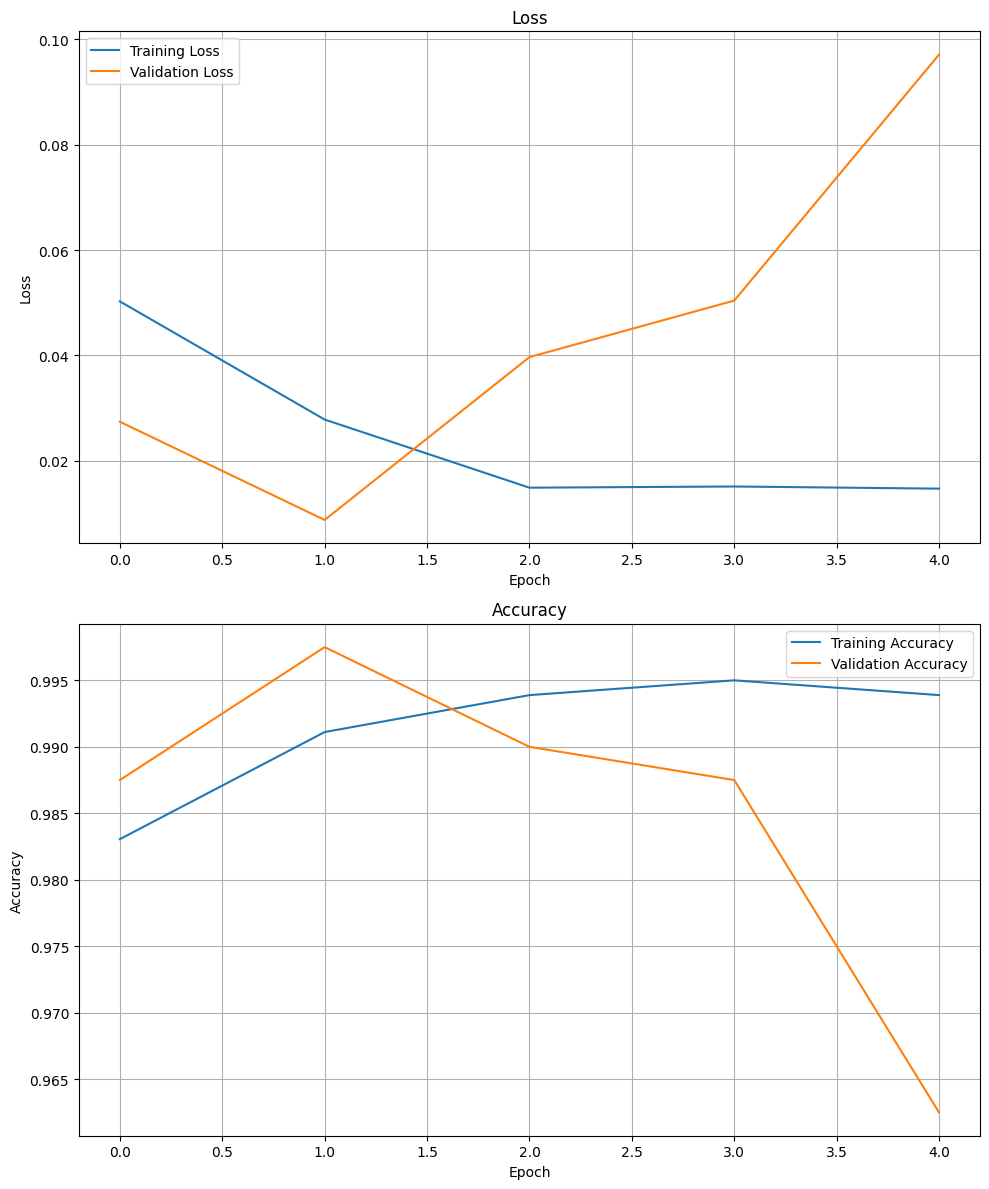

In [50]:
plt.figure(figsize=(10, 12))

# Plot Training Loss and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(data.loss, label='Training Loss')
plt.plot(data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Plot Training Accuracy and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(data.accuracy, label='Training Accuracy')
plt.plot(data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


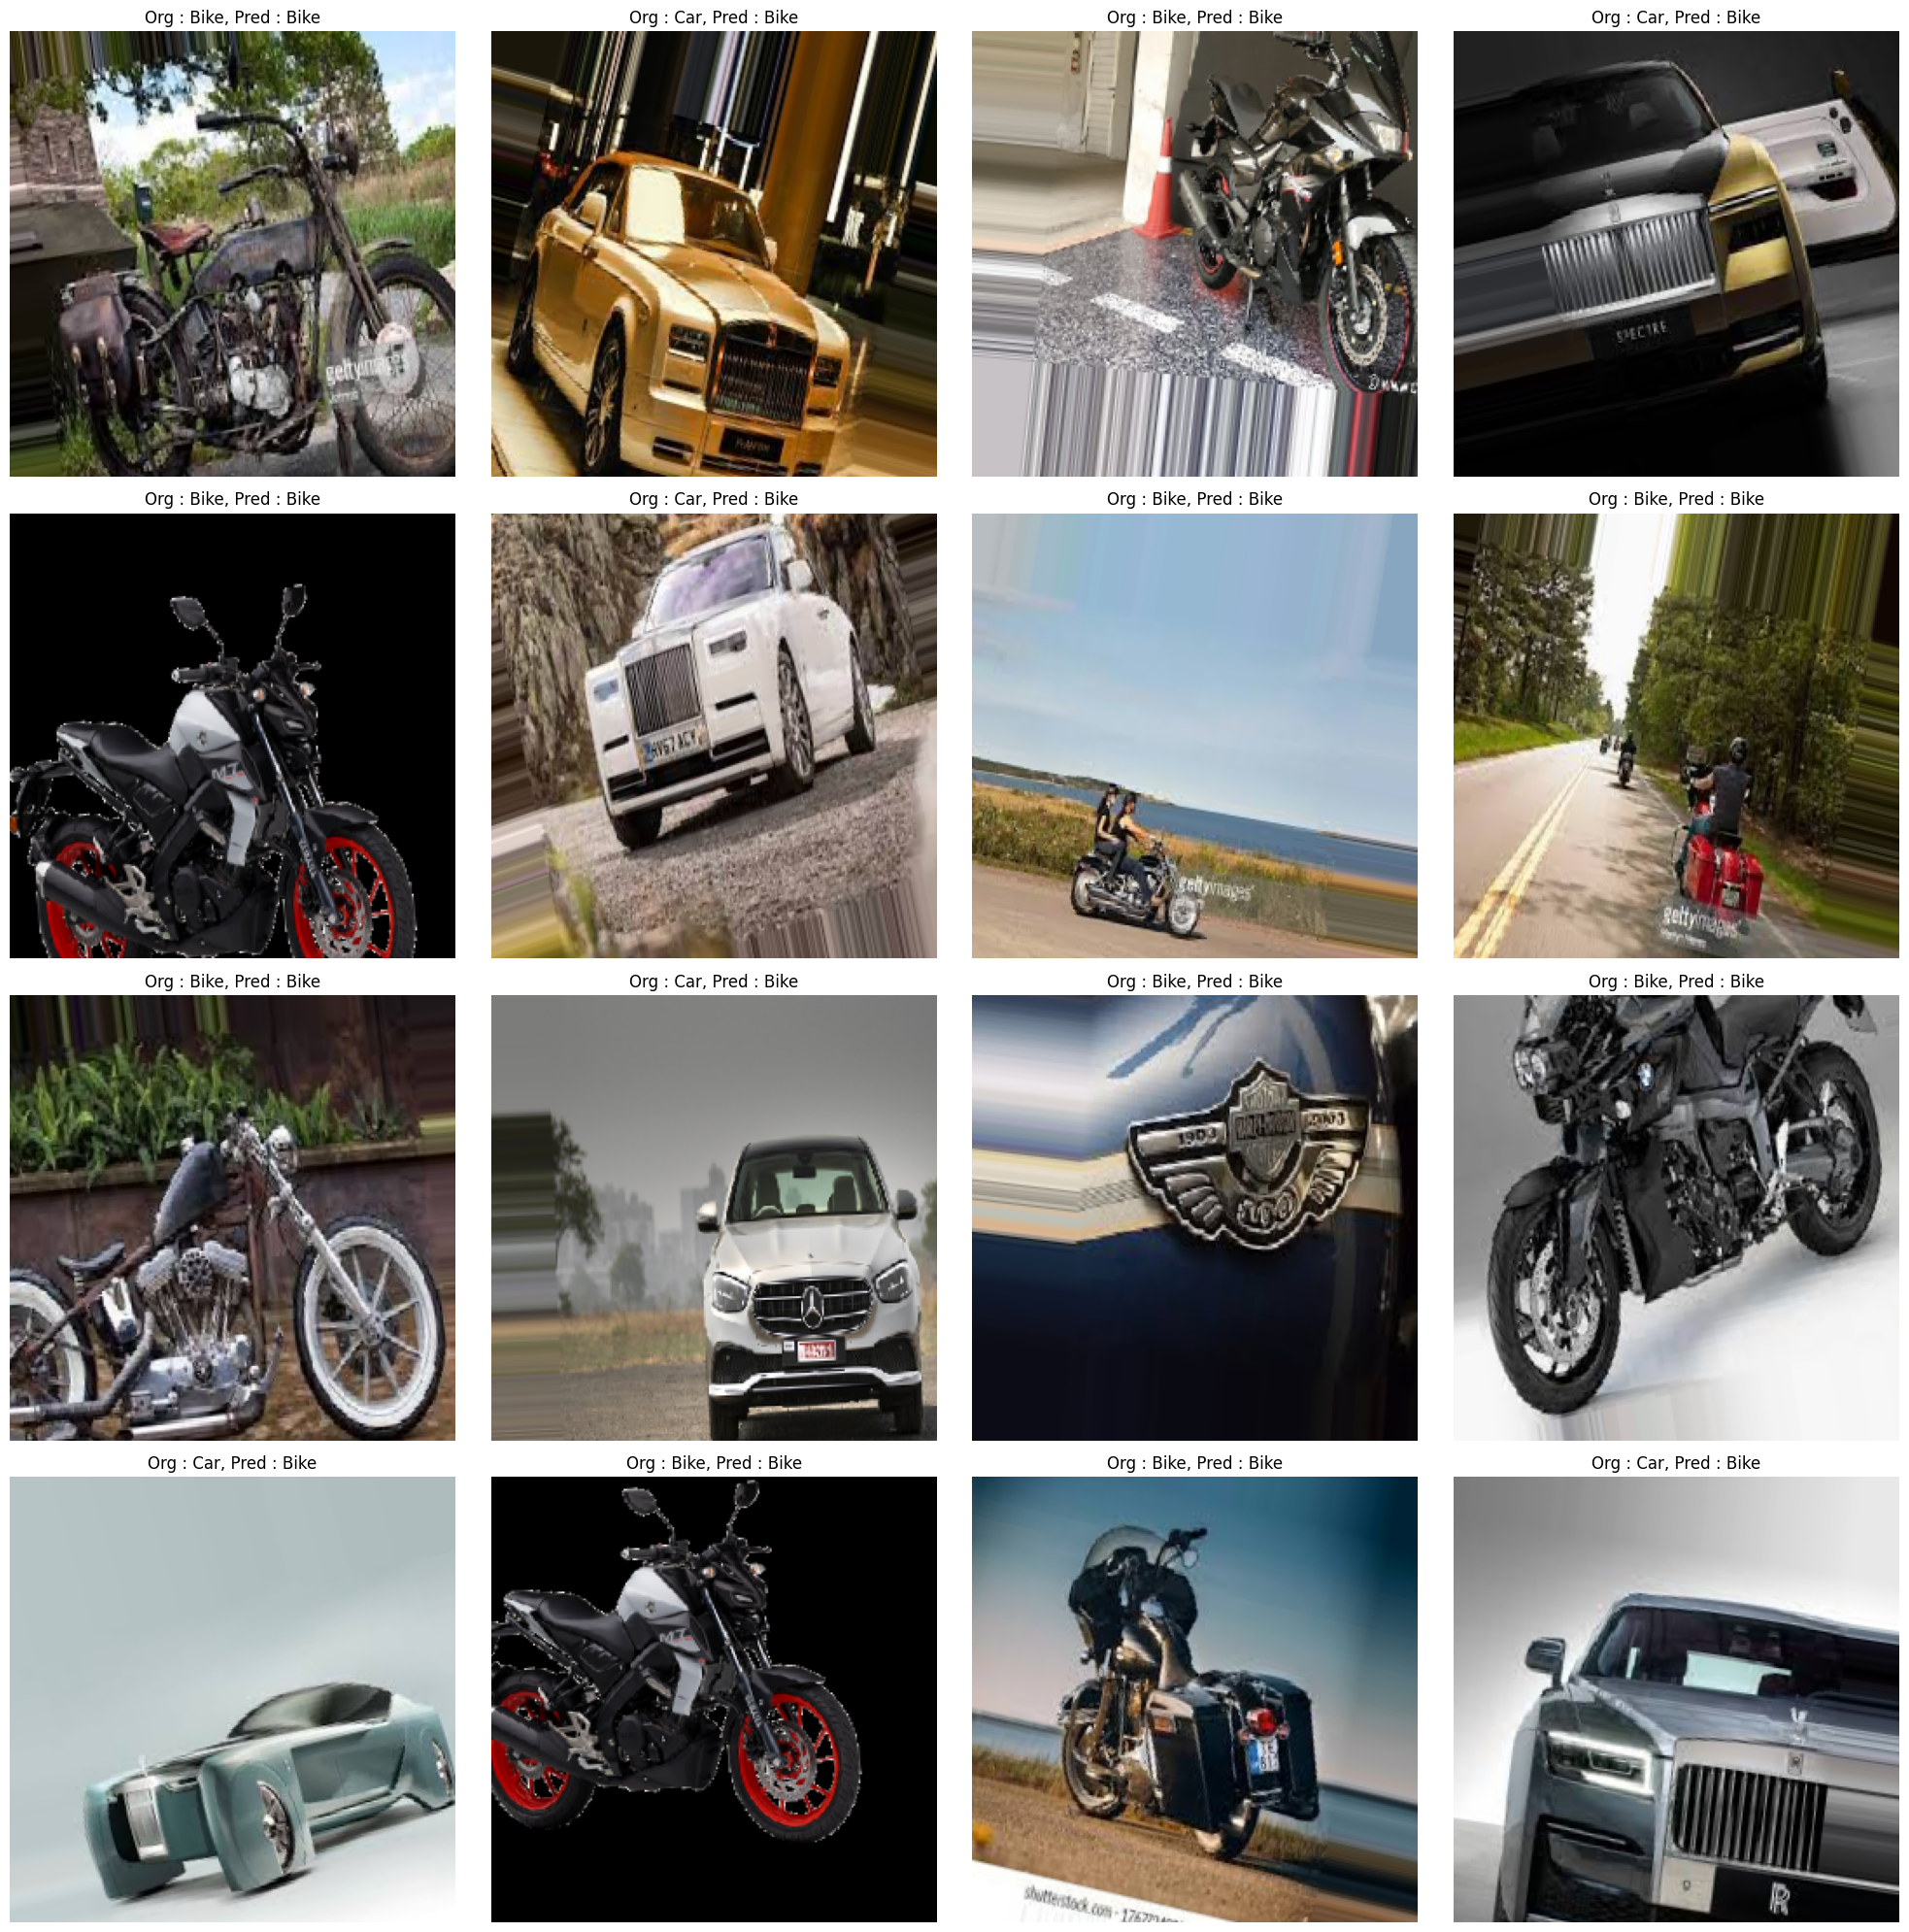

In [51]:
display_images(model=model, data=valid_ds)